In [1]:
%load_ext autoreload
%autoreload 2
### Set CUDA device
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [21]:
import sys, os
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import torch
import lightning as L
from monai.metrics import DiceMetric, HausdorffDistanceMetric, SurfaceDiceMetric
from torch.nn.functional import one_hot
import pandas as pd
import seaborn as sns

sys.path.append('../')
from data_utils import get_data_module
from model.unet import get_unet_module

In [22]:
SAVE = False

if SAVE:
    UNET_CKPTS = {
        "mnmv2": {
            'dropout-0-0': 'mnmv2_symphony_dropout-0-0_2025-01-14-15-20',
            'dropout-0-1': 'mnmv2_symphony_dropout-0-1_2025-01-14-15-19',
            'dropout-0-2': 'mnmv2_symphony_dropout-0-2_2025-01-14-15-18',
            'dropout-0-3': 'mnmv2_symphony_dropout-0-5_2025-01-14-15-20'
        },
        'pmri': {
            'dropout-0-0': 'pmri_runmc_dropout-0-0_2025-01-14-15-58',
            'dropout-0-1': 'pmri_runmc_dropout-0-1_2025-01-14-15-58',
            'dropout-0-2': 'pmri_runmc_dropout-0-2_2025-01-14-15-58',
            'dropout-0-5': 'pmri_runmc_dropout-0-5_2025-01-14-15-58'
        },
    }

    metrics = {}

    for dataset in ['mnmv2', 'pmri']:

        unet_cfg = OmegaConf.load('../configs/unet/monai_unet.yaml')


        if dataset == 'mnmv2':
            unet_cfg.out_channels = 4
            num_classes = 4
            data_cfg = OmegaConf.load('../configs/data/mnmv2.yaml')
            data_cfg.domain = 'Symphony'


        else:
            unet_cfg.out_channels = 1
            num_classes = 2
            data_cfg = OmegaConf.load('../configs/data/pmri.yaml')
            data_cfg.domain = 'RUNMC'


        results = {}
        data_cfg.dataset = dataset
        data_cfg.non_empty_target = True

        datamodule = get_data_module(
            cfg=data_cfg
        )

        datamodule.setup('test')

        ckpt = UNET_CKPTS[data_cfg.dataset]['dropout-0-1']
        unet_cfg.checkpoint_path = f'../../{unet_cfg.checkpoint_dir}{ckpt}.ckpt'

        unet = get_unet_module(
            cfg=unet_cfg,
            metadata=OmegaConf.to_container(unet_cfg),
            load_from_checkpoint=True
        )

        trainer = L.Trainer()

        predictions = trainer.predict(unet, datamodule.test_dataloader())
        predictions_clean = {d:
            {
                key: torch.cat([d[key] for d in m], dim=0) 
                for key in m[0].keys()
            } for d, m in zip(datamodule.test_dataloader().keys(), predictions)
        }

        metrics[dataset] = predictions_clean


        torch.save(metrics, '../../results/unet_eval.pt')

else:
    metrics = torch.load('../../results/unet_eval.pt')

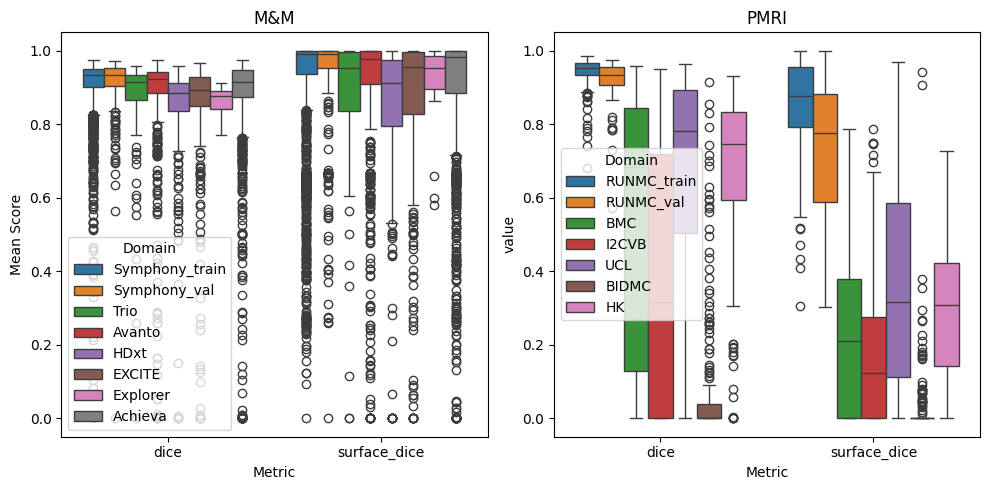

In [23]:
rows = []

for dataset, dataset_metrics in metrics.items():
    # print(dataset)
    for domain, domain_metrics in dataset_metrics.items():
        # print(domain)
        dice = domain_metrics['dice']
        # print(f'Dice Correlation: {dice_correlation}')
        surface_dice = domain_metrics['surface_dice']
        # print(f'Surface Dice Correlation: {surface_dice_correlation}')
        for score in ['dice', 'surface_dice']:
            value = dice if score == 'dice' else surface_dice
            for v in value:
                rows.append(
                    {
                        'Dataset': dataset,
                        'Domain': domain,
                        'value': v.item(),
                        'score': score
                    }
                )

df = pd.DataFrame(rows)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.boxplot(x='score', y='value', hue='Domain', data=df[df['Dataset'] == 'mnmv2'], ax=ax[0])
ax[0].set_title('M&M')
ax[0].set_ylabel('Mean Score')
ax[0].set_xlabel('Metric')
# ax[0].set_ylim(0.8, 1)

sns.boxplot(x='score', y='value', hue='Domain', data=df[df['Dataset'] == 'pmri'], ax=ax[1])
ax[1].set_title('PMRI')
ax[1].set_xlabel('Metric')

plt.tight_layout()


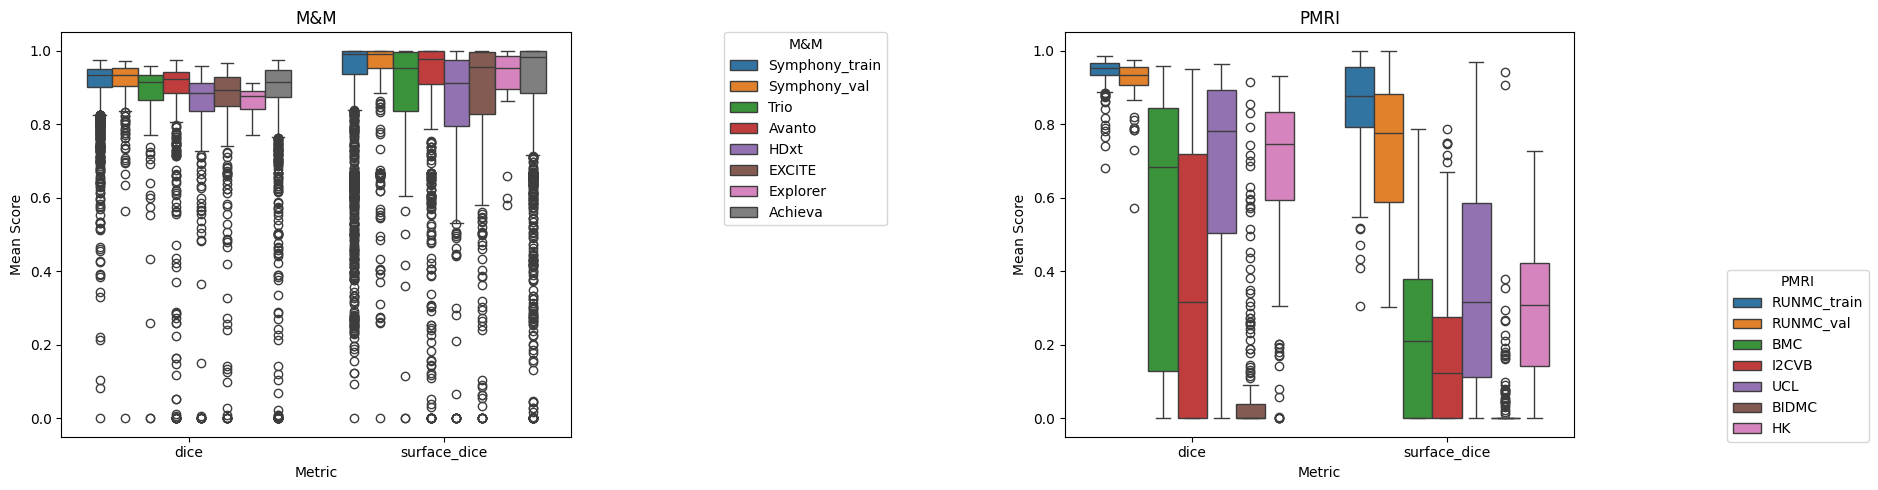

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(25, 5))

# M&M plot
sns.boxplot(x='score', y='value', hue='Domain', data=df[df['Dataset'] == 'mnmv2'], ax=ax[0])
ax[0].set_title('M&M')
ax[0].set_ylabel('Mean Score')
ax[0].set_xlabel('Metric')
# ax[0].set_ylim(0.8, 1)

# Move M&M legend
legend0 = ax[0].legend(title='M&M', bbox_to_anchor=(1.3, 1), loc='upper left', borderaxespad=0)

# PMRI plot
sns.boxplot(x='score', y='value', hue='Domain', data=df[df['Dataset'] == 'pmri'], ax=ax[1])
ax[1].set_title('PMRI')
ax[1].set_ylabel('Mean Score')
ax[1].set_xlabel('Metric')

# Move PMRI legend
legend1 = ax[1].legend(title='PMRI', bbox_to_anchor=(1.3, 0.2), loc='center left', borderaxespad=0)

# Adjust layout to make space for the legends
plt.tight_layout(rect=[0, 0, 0.8, 1])  # Leave space on the right for legends
# fig.savefig('../../results/plots/unet_eval.png', dpi=300)



In [35]:
quantiles = {}

for dataset in ['mnmv2', 'pmri']:
    quantiles[dataset] = {}
    for score in ['dice', 'surface_dice']:
        quantiles[dataset][score] = {}
        domain = 'Symphony_train' if dataset == 'mnmv2' else 'RUNMC_train'
        filtered_df = df[(df['Dataset'] == dataset) & (df['score'] == score) & (df['Domain'] == domain)]

        # find 90% quantile in score
        quantiles[dataset][score]['q_80'] = filtered_df['value'].quantile(0.2)
        quantiles[dataset][score]['q_90'] = filtered_df['value'].quantile(0.1)
        # print(f'{dataset} {score} 90% above {q_90:.4f}')
        quantiles[dataset][score]['q_95'] = filtered_df['value'].quantile(0.05)

        # print(f'{dataset} {score} 95% above {q_95:.4f}')

print(quantiles)

{'mnmv2': {'dice': {'q_80': 0.8865002393722534, 'q_90': 0.8443227410316467, 'q_95': 0.7935258209705353}, 'surface_dice': {'q_80': 0.8983537554740906, 'q_90': 0.6614245891571044, 'q_95': 0.5942456066608429}}, 'pmri': {'dice': {'q_80': 0.9288250088691712, 'q_90': 0.9120014429092407, 'q_95': 0.8903486222028733}, 'surface_dice': {'q_80': 0.77085782289505, 'q_90': 0.6924475610256196, 'q_95': 0.6237157493829727}}}


In [26]:
filtered_df

,Dataset,Domain,value,score
12980,pmri,RUNMC_val,0.940447,dice
12981,pmri,RUNMC_val,0.968461,dice
12982,pmri,RUNMC_val,0.935007,dice
12983,pmri,RUNMC_val,0.933358,dice
12984,pmri,RUNMC_val,0.974201,dice
12985,pmri,RUNMC_val,0.729671,dice
12986,pmri,RUNMC_val,0.907430,dice
12987,pmri,RUNMC_val,0.948374,dice
12988,pmri,RUNMC_val,0.819721,dice
12989,pmri,RUNMC_val,0.948404,dice


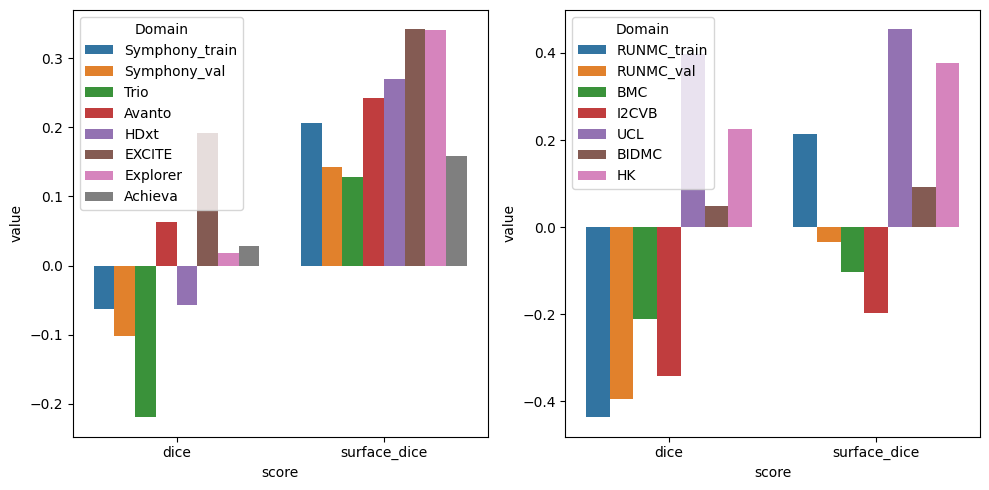

In [48]:
rows = []

for dataset, dataset_metrics in metrics.items():
    # print(dataset)
    for domain, domain_metrics in dataset_metrics.items():
        # print(domain)
        dice_correlation = torch.corrcoef(torch.stack([domain_metrics['entropy'], domain_metrics['dice']]))[0, 1]
        # print(f'Dice Correlation: {dice_correlation}')
        surface_dice_correlation = torch.corrcoef(torch.stack([domain_metrics['entropy'], domain_metrics['surface_dice']]))[0, 1]
        # print(f'Surface Dice Correlation: {surface_dice_correlation}')
        for score in ['dice', 'surface_dice']:

            rows.append(
                {
                    'Dataset': dataset,
                    'Domain': domain,
                    'value': dice_correlation.item() if score == 'dice' else surface_dice_correlation.item(),
                    'score': score
                }
            )

df = pd.DataFrame(rows)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.barplot(x='score', y='value', hue='Domain', data=df[df['Dataset'] == 'mnmv2'], ax=ax[0])
sns.barplot(x='score', y='value', hue='Domain', data=df[df['Dataset'] == 'pmri'], ax=ax[1])

plt.tight_layout()

In [1]:
from monai.networks.nets import ResNet

In [16]:
spatial_dims = 2
in_channels = 64
block='basic'
num_classes = 2
layers = [4,4,4,4]
block_inplanes = [64,64,64,64]

model = ResNet(
    block=block,
    layers=layers,
    n_input_channels=in_channels,
    block_inplanes=block_inplanes,
    spatial_dims=spatial_dims,
    num_classes=num_classes
)


In [17]:
print("Trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Trainable parameters: 1397570


In [18]:
import torch

input = torch.ones([1, 64, 96, 96])
output = model(input)